 # Project 1 - CITS5017 Deep Learning

### Long qin (23829101)

# 0. Libraries

In [1]:
import os
import time
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Resizing
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

# 1. The Image Dataset

### Download and explore the data:

In [2]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

# Load training and validation data
X_train, y_train, class_names = load_data("train.pkl")
X_val, y_val, _ = load_data("val.pkl")

# Print shapes and data types
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_train dtype:", X_train.dtype)
print("X_val dtype:", X_val.dtype)

# Verify class distribution
print("Number of instances per class in training set:")
for i in range(10):
    print(f"Class {i}: {np.sum(y_train == i)}")

print("\nNumber of instances per class in validation set:")
for i in range(10):
    print(f"Class {i}: {np.sum(y_val == i)}")

# Shuffle the training set
X_train_orig, y_train = shuffle(X_train, y_train, random_state=42)

# Optionally shuffle the validation set
X_val_orig, y_val = shuffle(X_val, y_val, random_state=42)

# Normalize the data
X_train = X_train_orig.astype(np.float32) / 255.0
X_val = X_val_orig.astype(np.float32) / 255.0

print("\nAfter normalization:")
print("X_train dtype:", X_train.dtype)
print("X_val dtype:", X_val.dtype)
print("X_train range:", X_train.min(), "-", X_train.max())
print("X_val range:", X_val.min(), "-", X_val.max())

X_train shape: (2000, 64, 64, 3)
X_val shape: (500, 64, 64, 3)
X_train dtype: uint8
X_val dtype: uint8
Number of instances per class in training set:
Class 0: 200
Class 1: 200
Class 2: 200
Class 3: 200
Class 4: 200
Class 5: 200
Class 6: 200
Class 7: 200
Class 8: 200
Class 9: 200

Number of instances per class in validation set:
Class 0: 50
Class 1: 50
Class 2: 50
Class 3: 50
Class 4: 50
Class 5: 50
Class 6: 50
Class 7: 50
Class 8: 50
Class 9: 50

After normalization:
X_train dtype: float32
X_val dtype: float32
X_train range: 0.0 - 1.0
X_val range: 0.0 - 1.0


#### Based on the output above, it meets the requirements of The Image Dataset.

 # 2. Tasks

## 2.1 Displaying Randomly Sampled Images with Class Labels

### 2.1.1 Write the tunction `displayImages`:

In [3]:

def displayImages(X, y, class_names, num_images=20, rows=4, cols=5, predictions=None, title="Sampled Images"):
    """
    Display a specified number of images from the dataset with their class names and optional predictions.
    
    Args:
    X (np.array): Image data with shape (num_samples, height, width, channels)
    y (np.array): True labels for the images
    class_names (list): List of class names corresponding to the labels
    num_images (int): Number of images to display (default: 20)
    rows (int): Number of rows in the plot (default: 4)
    cols (int): Number of columns in the plot (default: 5)
    predictions (np.array): Predicted labels for the images (optional)
    title (str): Title for the plot (default: "Sampled Images")
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    fig.suptitle(title, fontsize=20)
    
    # If predictions are not provided, we'll use random sampling
    if predictions is None:
        indices = np.random.choice(len(X), num_images, replace=False)
    else:
        indices = range(min(num_images, len(X)))
    
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            img = X[indices[i]]
            true_label = y[indices[i]]
            
            # If the image data is normalized (0-1), scale it back to 0-255 for display
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            
            ax.imshow(img)
            ax.axis('off')
            
            if predictions is None:
                ax.set_title(f"{class_names[true_label]}", fontsize=15)
            else:
                pred_label = predictions[indices[i]]
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                             color=color, fontsize=18)
    
    plt.tight_layout()
    plt.show()

### 2.1.2 Display 20 images are from training set:

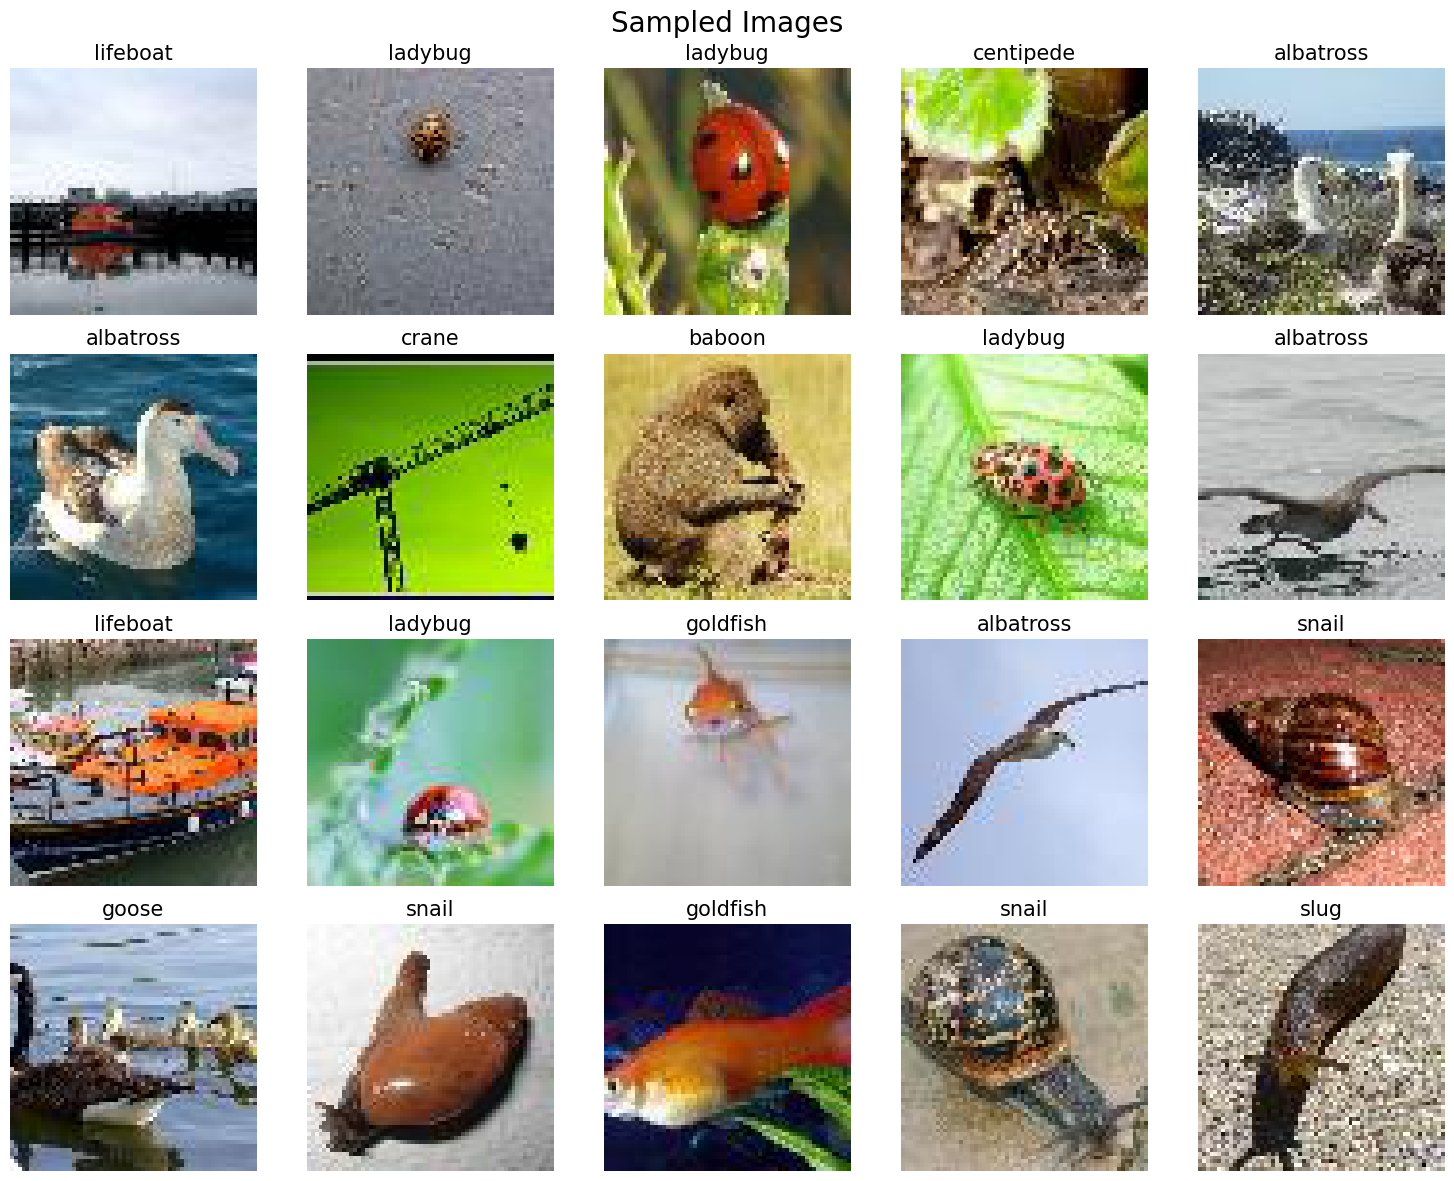

In [4]:

displayImages(X_train, y_train, class_names)


#### 2.1.2 Display 20 images from validation set:

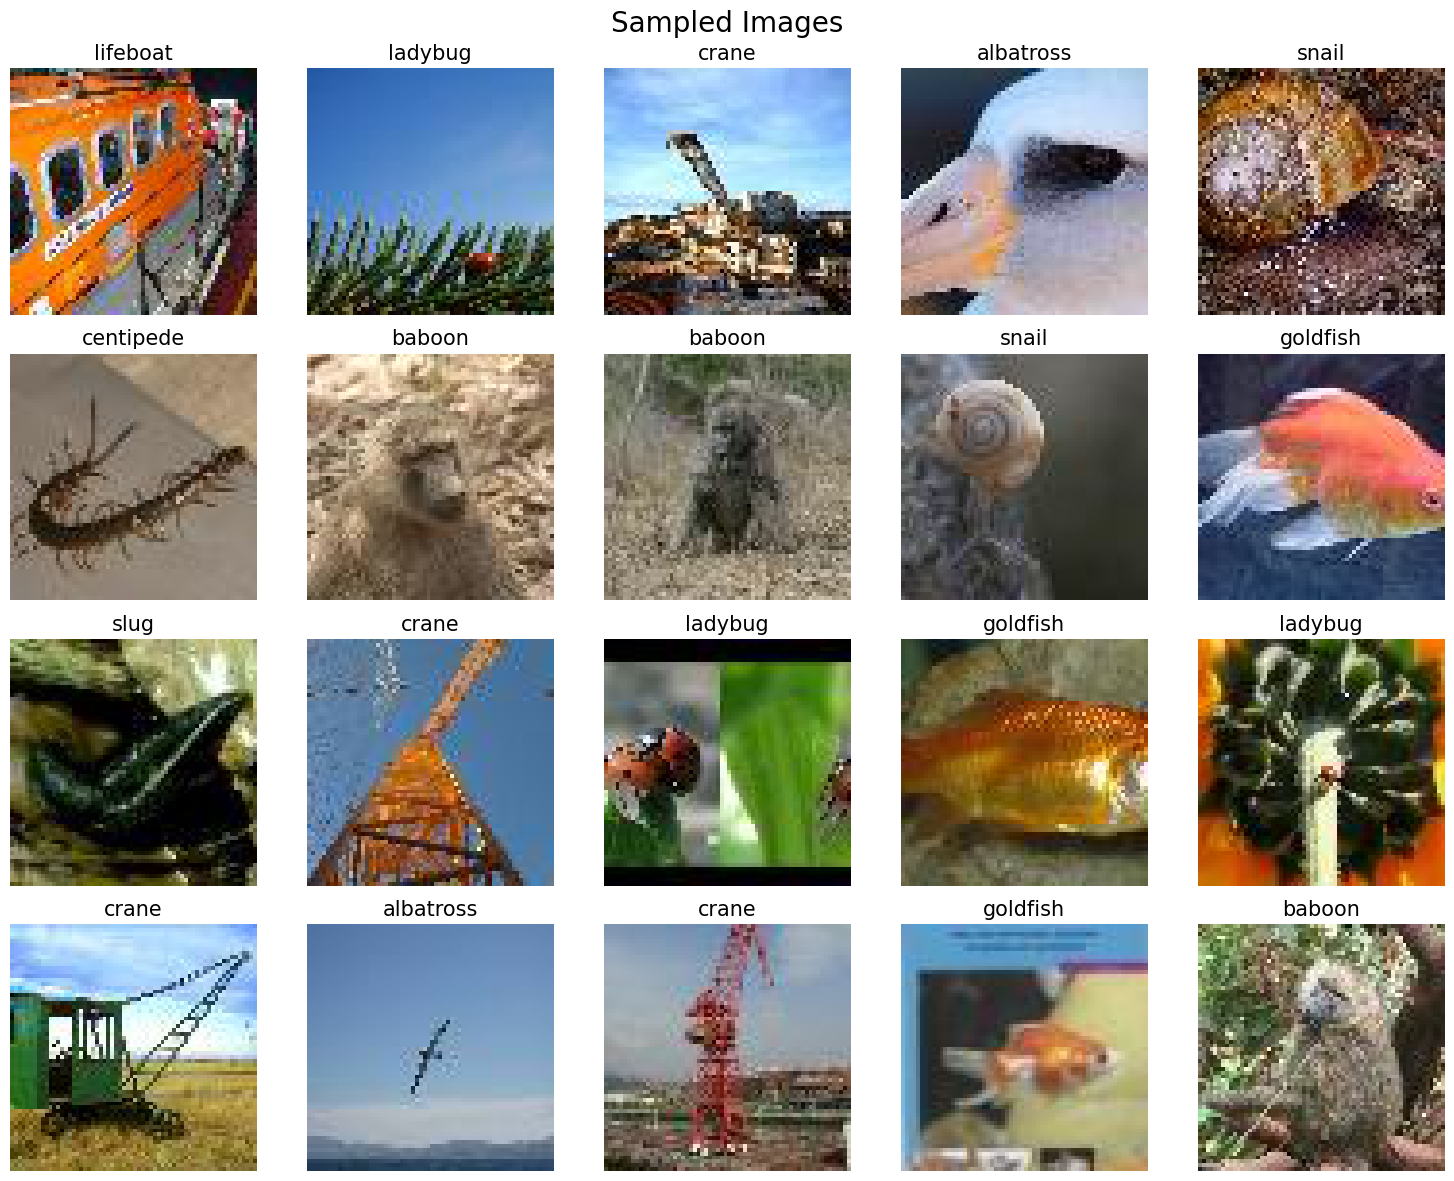

In [5]:
displayImages(X_val, y_val, class_names)

## 2.2 Implementation of a CNN

### 2.2.1  Write CNN Model Builder Function:

In [6]:

def build_cnn_model(input_shape, num_classes, kernel_size, num_kernels, dropout_rate):
    """
    Parameters:
    - input_shape (tuple): (height, width, channels).
    - num_classes (int): Number of output classes for classification.
    - kernel_size (int or tuple): Size of the convolutional kernels (filters).
    - num_kernels (int): Number of kernels in the first convolutional layer.
    - dropout_rate (float): Dropout rate for regularization, between 0 and 1.
    Returns:
    - model (tf.keras.Model): Compiled CNN model.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),  # use Input as first layer.
        layers.Conv2D(num_kernels, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(num_kernels*2, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(num_kernels*4, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(num_kernels*8, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    
    optimizer = Adam(learning_rate=lr_schedule)   
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



### 2.2.2 Hyperparameter Tuning - MARKDOWN

#### 2.2.2.1 Write the tuning code:

```
# Define the hyperparameter grid
kernel_sizes = [3, 5]
num_kernels_options = [32, 64]
dropout_rates = [0.3, 0.5]

# Iterate over each combination of hyperparameters
for kernel_size in kernel_sizes:
    for num_kernels in num_kernels_options:
        for dropout_rate in dropout_rates:
            print(f"Training with kernel_size={kernel_size}, num_kernels={num_kernels},
                        dropout_rate={dropout_rate}")

            # Current set of hyperparameters
            model = build_cnn_model(input_shape=(64, 64, 3), 
                                    num_classes=10, 
                                    kernel_size=kernel_size, 
                                    num_kernels=num_kernels, 
                                    dropout_rate=dropout_rate)
                                    
            # Set up early stopping to monitor validation accuracy
            early_stopping = EarlyStopping(monitor='val_accuracy',
                                    patience=5, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, y_train, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(X_val, y_val),
                                callbacks=[early_stopping],
                                verbose=0)
            
            val_accuracy = max(history.history['val_accuracy'])

            print(f"Validation Accuracy: {val_accuracy:.4f}")

```

#### 2.2.2.2 Tuning output:

| Kernel Size | Num Kernels | Dropout Rate | Validation Accuracy |
|-------------|-------------|--------------|---------------------|
| 3           | 32          | 0.3          | 0.5720              |
| 3           | 32          | 0.5          | 0.5700              |
| 3           | 64          | 0.3          | **0.6100**              |
| 3           | 64          | 0.5          | **0.6120**              |
| 5           | 32          | 0.3          | 0.5620              |
| 5           | 32          | 0.5          | 0.4920              |
| 5           | 64          | 0.3          | 0.4720              |
| 5           | 64          | 0.5          | 0.5600              |

#### 2.2.2.3 Hyperparameter Tuning Analysis



I experimented with the following hyperparameter values:
- Kernel Size: 3x3, 5x5
- Number of Initial Kernels: 32, 64
- Dropout Rate: 0.3, 0.5

##### Observations:
- Starting with 64 kernels showed better performance than 32, indicating that the model benefits from higher capacity in the initial layers.
- A dropout rate of 0.5 slightly outperformed 0.3.
- The close performance between dropout rates 0.5 and 0.3 (61.20% vs 61.00%) indicates that the model's performance is relatively stable with respect to this hyperparameter.

Best Hyperparameters:
- Kernel Size: 3
- Number of Kernels: 64
- Dropout Rate: 0.5
- Best Validation Accuracy: 0.6120


## 2.3 Structure of the code

### 2.3.1 Code and output:

In [7]:
# Best hyperparameters from tuning
best_kernel_size = 3
best_num_kernels = 64
best_dropout_rate = 0.3


In [8]:
# Class for time per epoch
class TimePerEpochCallback(Callback):
        def __init__(self):
            self.times = []
            self.start_time = None
    
        def on_epoch_begin(self, epoch, logs=None):
            self.start_time = time.time()
    
        def on_epoch_end(self, epoch, logs=None):
            epoch_time = time.time() - self.start_time
            self.times.append(epoch_time)
               

Training model from scratch...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 335ms/step - accuracy: 0.2408 - loss: 2.5160 - val_accuracy: 0.1040 - val_loss: 2.7380
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.3882 - loss: 1.8514 - val_accuracy: 0.1000 - val_loss: 3.7052
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.4118 - loss: 1.7186 - val_accuracy: 0.1000 - val_loss: 3.0290
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.4946 - loss: 1.4310 - val_accuracy: 0.1320 - val_loss: 2.7759
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.5498 - loss: 1.3387 - val_accuracy: 0.1620 - val_loss: 2.8528
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.6152 - loss: 1.1404 - val_accuracy: 0.2140 - val_loss: 2.3458
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.6326 - loss: 1.0677 - val_accuracy: 0.2240 - val_loss: 2.3736
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - acc

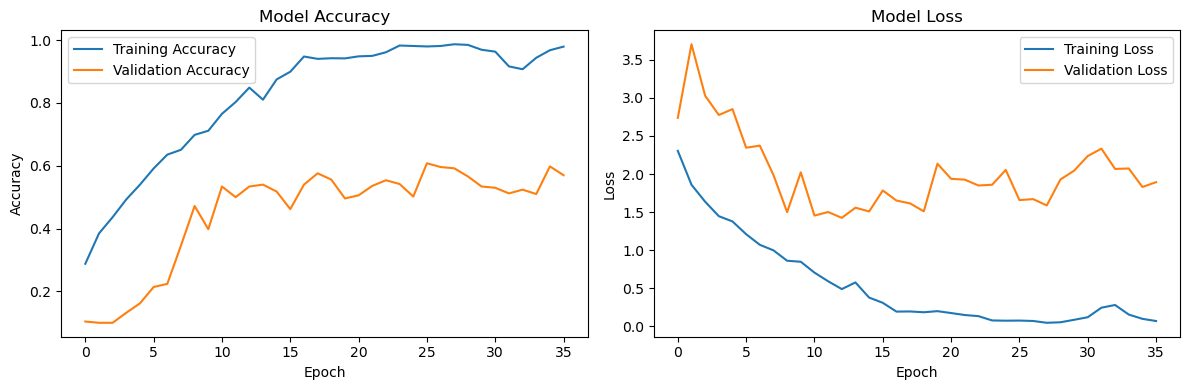


Evaluating on Training Set:
Training Accuracy CNN: 0.9990

Evaluating on Validation Set:
Validation Accuracy CNN: 0.6080
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [9]:

# File name for the saved model
model_filename = "Qin_Long-CNN.keras"

# Check if the model file exists
if os.path.exists(model_filename):
    print("Loading existing model...")
    model = load_model(model_filename)
    
    # create a new optimizer and use a tinny learning rate
    new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    
    model.compile(optimizer=new_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, 
                        epochs=1, 
                        batch_size=32, 
                        validation_data=(X_val, y_val))
else:
    print("Training model from scratch...")
    model = build_cnn_model(input_shape=(64, 64, 3), 
                            num_classes=10, 
                            kernel_size=best_kernel_size, 
                            num_kernels=best_num_kernels, 
                            dropout_rate=best_dropout_rate)

    
    # Callbacks early_stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    
    model_checkpoint = ModelCheckpoint(model_filename, save_best_only=True, monitor='val_accuracy')

    time_callback = TimePerEpochCallback()

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, time_callback])
    print("\n")
    # After training, you can access the times
    average_time_per_epoch = sum(time_callback.times) / len(time_callback.times)
    print(f"CNN Average time per epoch: {average_time_per_epoch:.1f} seconds")

    print("\n")
    # Get the best epoch
    best_epoch = early_stopping.best_epoch

     # Print the best epoch
    print(f"Best model was saved at epoch: {best_epoch + 1}")
    print("\n")
    # Plot learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate the model
print("\nEvaluating on Training Set:")
train_loss_cnn, train_accuracy_cnn = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy CNN: {train_accuracy_cnn:.4f}")

print("\nEvaluating on Validation Set:")
val_loss_cnn, val_accuracy_cnn = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy CNN: {val_accuracy_cnn:.4f}")

# Make predictions
train_predictions_cnn = model.predict(X_train)
val_predictions_cnn = model.predict(X_val)


### 2.3.2 CNN Model Performance Analysis
#### Observations:
- Validation Accuracy: **60.80%**
- Best val-performances achieved at `epoch`:  **26**.
#### Explaination:
1. Adam Optimizer and  ExponentialDecay
   - Adjusts the learning rate using the schedule to help the model converge better
2. Loss Function
   - loss=`'sparse_categorical_crossentropy'`: Used for classification problems



## 2.4 Transfer learning using MobileNetV2

### 2.4.1 Inspecting MobileNetV2 Architecture

In [9]:
# load MobileNetV2 model
model_MobileNetV2 = tf.keras.applications.MobileNetV2()

# print the Input Shape
print("Input shape:", model_MobileNetV2.input_shape)

# output Shape
print("Output shape:", model_MobileNetV2.output_shape)

# Print the total number of layers in the model
print("Total number of layers:", len(model_MobileNetV2.layers))


Input shape: (None, 224, 224, 3)
Output shape: (None, 1000)
Total number of layers: 156


#### Original images
- **Input Images**: Originally `64x64` pixels.
- **Classification Task**: 10-class classification.
  
#### MobileNetV2 Output Analysis:
1. **Dropping the Last Layer (Fully Connected Layer)**:
   - MobileNetV2 is designed for a `1000-class` classification by default.
   - I remove the final layer and replace it with a custom layer for the `10-class` task, by setting `include_top=False`

2. **Resizing Input Images to `96x96`**:
   - Using `64x64` might limit the amount of feature information extracted by the model.
   - Resizing the input images to `96x96` provides a good balance between detail and computational cost.

### 2.4.2 Construct MobileNetV2 model:

In [10]:
# construct MobileNetV2 model
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
avg = GlobalAveragePooling2D()(base_model.output)
den= Dense(128, activation='relu')(avg)
output = Dense(10, activation='softmax')(den)
model = Model(inputs=base_model.input, outputs=output)


### 2.4.3 Showt the firt and last 5 layers:

In [11]:
#  Get the name of the first and fifth layers
first_layer_name = model.layers[0].name
fifth_layer_name = model.layers[4].name

#Get the name of the fifth-last and last layers
fifth_last_layer_name = model.layers[-5].name
last_layer_name = model.layers[-1].name

# Display the first 5 layers
print("\nFirst 5 layers:\n")
model.summary(line_length=80, show_trainable=True, layer_range=[first_layer_name, fifth_layer_name])

# Display the last 5 layers
print("\nLast 5 layers:\n")
model.summary(line_length=80, show_trainable=True, layer_range=[fifth_last_layer_name, last_layer_name])



First 5 layers:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃    Param # ┃ Connected to    ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1      │ (None, 96, 96,   │          0 │ -               │   -   │
│ (InputLayer)       │ 3)               │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ Conv1 (Conv2D)     │ (None, 48, 48,   │        864 │ input_layer_1[… │   Y   │
│                    │ 32)              │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ bn_Conv1           │ (None, 48, 48,   │        128 │ Conv1[0][0]     │   Y   │
│ (BatchNormalizati… │ 32)              │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ Conv1_relu (ReLU)  │ (None, 48, 48,   │          0 │ bn_Conv1[0][0]  │   -   │
│                    │ 32)              │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ expanded_conv_dep… │ (None, 48, 48,   │        288 │ Conv1_relu[0][… │   Y   │
│ (DepthwiseConv2D)  │ 32)              │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ expanded_conv_dep… │ (None, 48, 48,   │        128 │ expanded_conv_… │   Y   │
│ (BatchNormalizati… │ 32)              │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ expanded_conv_dep… │ (None, 48, 48,   │          0 │ expanded_conv_… │   -   │
│ (ReLU)             │ 32)              │            │                 │       │
└────────────────────┴──────────────────┴────────────┴─────────────────┴───────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)


Last 5 layers:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃    Param # ┃ Connected to    ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Conv_1_bn          │ (None, 3, 3,     │      5,120 │ Conv_1[0][0]    │   Y   │
│ (BatchNormalizati… │ 1280)            │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ out_relu (ReLU)    │ (None, 3, 3,     │          0 │ Conv_1_bn[0][0] │   -   │
│                    │ 1280)            │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ global_average_po… │ (None, 1280)     │          0 │ out_relu[0][0]  │   -   │
│ (GlobalAveragePoo… │                  │            │                 │       │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ dense (Dense)      │ (None, 128)      │    163,968 │ global_average… │   Y   │
├────────────────────┼──────────────────┼────────────┼─────────────────┼───────┤
│ dense_1 (Dense)    │ (None, 10)       │      1,290 │ dense[0][0]     │   Y   │
└────────────────────┴──────────────────┴────────────┴─────────────────┴───────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 2.4.4 Training with Frozen Base Model Layers

In [12]:
# resize - the code is from the cits5017 slides directly
X_train_float = tf.cast(X_train_orig, tf.float32)
x1 = tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=True)(X_train_float)
X_train_resized = tf.keras.applications.mobilenet_v2.preprocess_input(x1)

# resize - the code is from the cits5017 slides directly
X_val_float = tf.cast(X_val_orig, tf.float32)
x2 = tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=True)(X_val_float)
X_val_resized = tf.keras.applications.mobilenet_v2.preprocess_input(x2)

In [13]:
#  Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an Adam optimizer 
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with frozen base layers
history_frozen = model.fit(X_train_resized, y_train, epochs=3, validation_data=(X_val_resized, y_val), batch_size=32)


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.6215 - loss: 1.1497 - val_accuracy: 0.8480 - val_loss: 0.4377
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9290 - loss: 0.2319 - val_accuracy: 0.8680 - val_loss: 0.3877
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9806 - loss: 0.0870 - val_accuracy: 0.8580 - val_loss: 0.4261


### 2.4.5 Unfreezing Layers and evaluating

In [14]:
# Unfreeze layers from the 90th onward
for layer in model.layers[90:]:
    layer.trainable = True

# Recompile the model with a very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the unfrozen layers
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Save the model as required
model_checkpoint = ModelCheckpoint("Qin_Long-MobileNetV2.keras", save_best_only=True)

time_callback = TimePerEpochCallback()

history_unfrozen = model.fit(X_train_resized, y_train, epochs=30, 
                             validation_data=(X_val_resized, y_val), 
                             batch_size=32, callbacks=[early_stopping, model_checkpoint,time_callback])
print("\n")
# After training, you can access the times
average_time_per_epoch = sum(time_callback.times) / len(time_callback.times)
print(f"Mobile Average time per epoch: {average_time_per_epoch:.1f} seconds")
print("\n")
# Get the best epoch
best_epoch_MobileNetV2 = early_stopping.best_epoch
# Print the best epoch
print(f"Best MobileNetV2 model was saved at epoch: {best_epoch_MobileNetV2 + 1}")
print("\n")

# Make predictions on the training and validation sets
y_train_pred_mob = model.predict(X_train_resized).argmax(axis=1)
y_val_pred_mob = model.predict(X_val_resized).argmax(axis=1)

# Compute and display the accuracy scores
train_accuracy_mob = accuracy_score(y_train, y_train_pred_mob)
val_accuracy_mob = accuracy_score(y_val, y_val_pred_mob)
print(f"Training Accuracy: {train_accuracy_mob:.4f}")
print(f"Validation Accuracy: {val_accuracy_mob:.4f}")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - accuracy: 0.8541 - loss: 0.4433 - val_accuracy: 0.8580 - val_loss: 0.4109
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9219 - loss: 0.2566 - val_accuracy: 0.8720 - val_loss: 0.4005
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9414 - loss: 0.2173 - val_accuracy: 0.8740 - val_loss: 0.3957
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9431 - loss: 0.1866 - val_accuracy: 0.8800 - val_loss: 0.3818
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.9620 - loss: 0.1483 - val_accuracy: 0.8820 - val_loss: 0.3772
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9700 - loss: 0.1263 - val_accuracy: 0.8800 - val_loss: 0.3736
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.9807 - loss: 0.1123 - val_accuracy: 0.8840 - val_loss: 0.3722
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9790 - loss: 0.1087 - val_accu

### Validation Accuracy: **0.8840**
#### Explaination:
- Time per epoch:     **14.0s**
- **reisze** has a great impact on the training performance.

### 2.4.6 Confusion Matrix Visualization

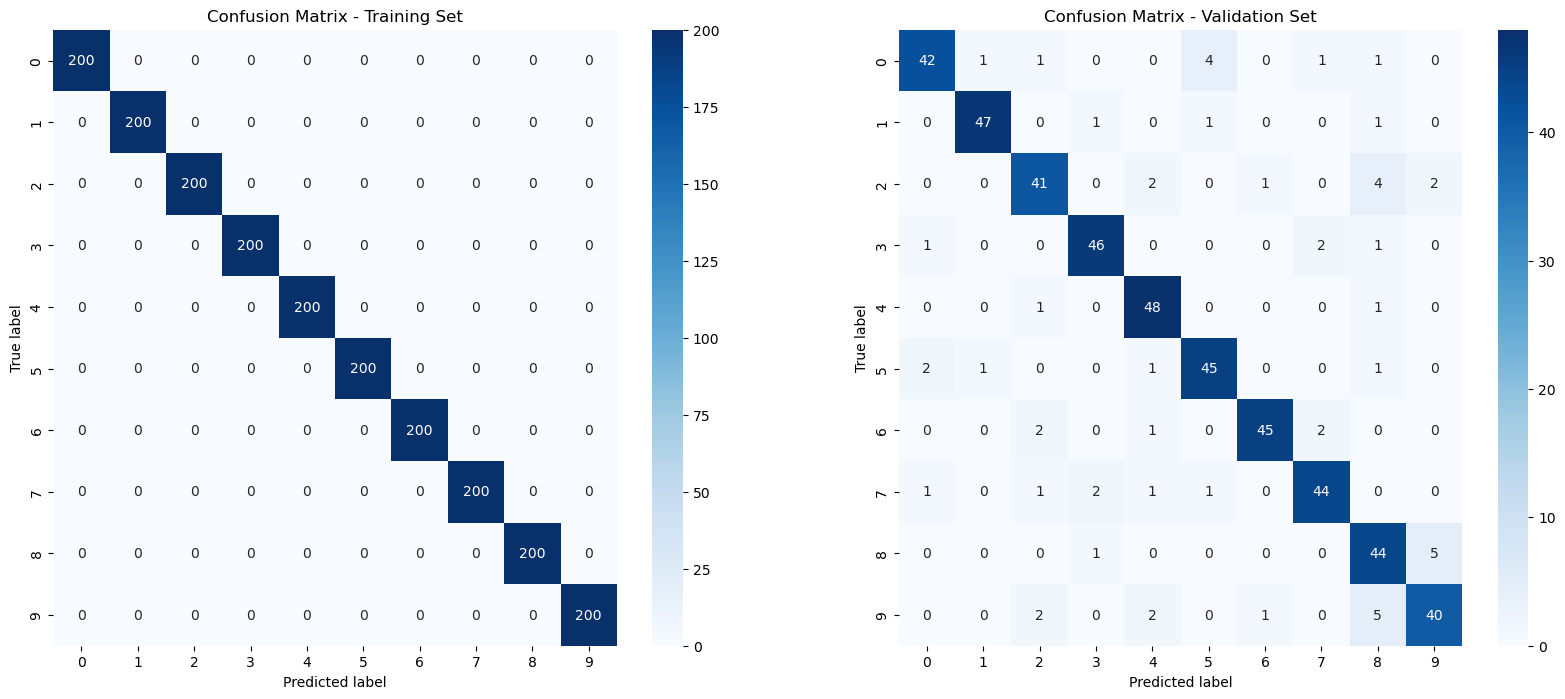

In [15]:
#  calculate confusion_matrix  
cm_train = confusion_matrix(y_train, y_train_pred_mob)
cm_val = confusion_matrix(y_val, y_val_pred_mob)

#   plot  confusion_matrix 
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### 2.4.7 Visualizing Model Predictions

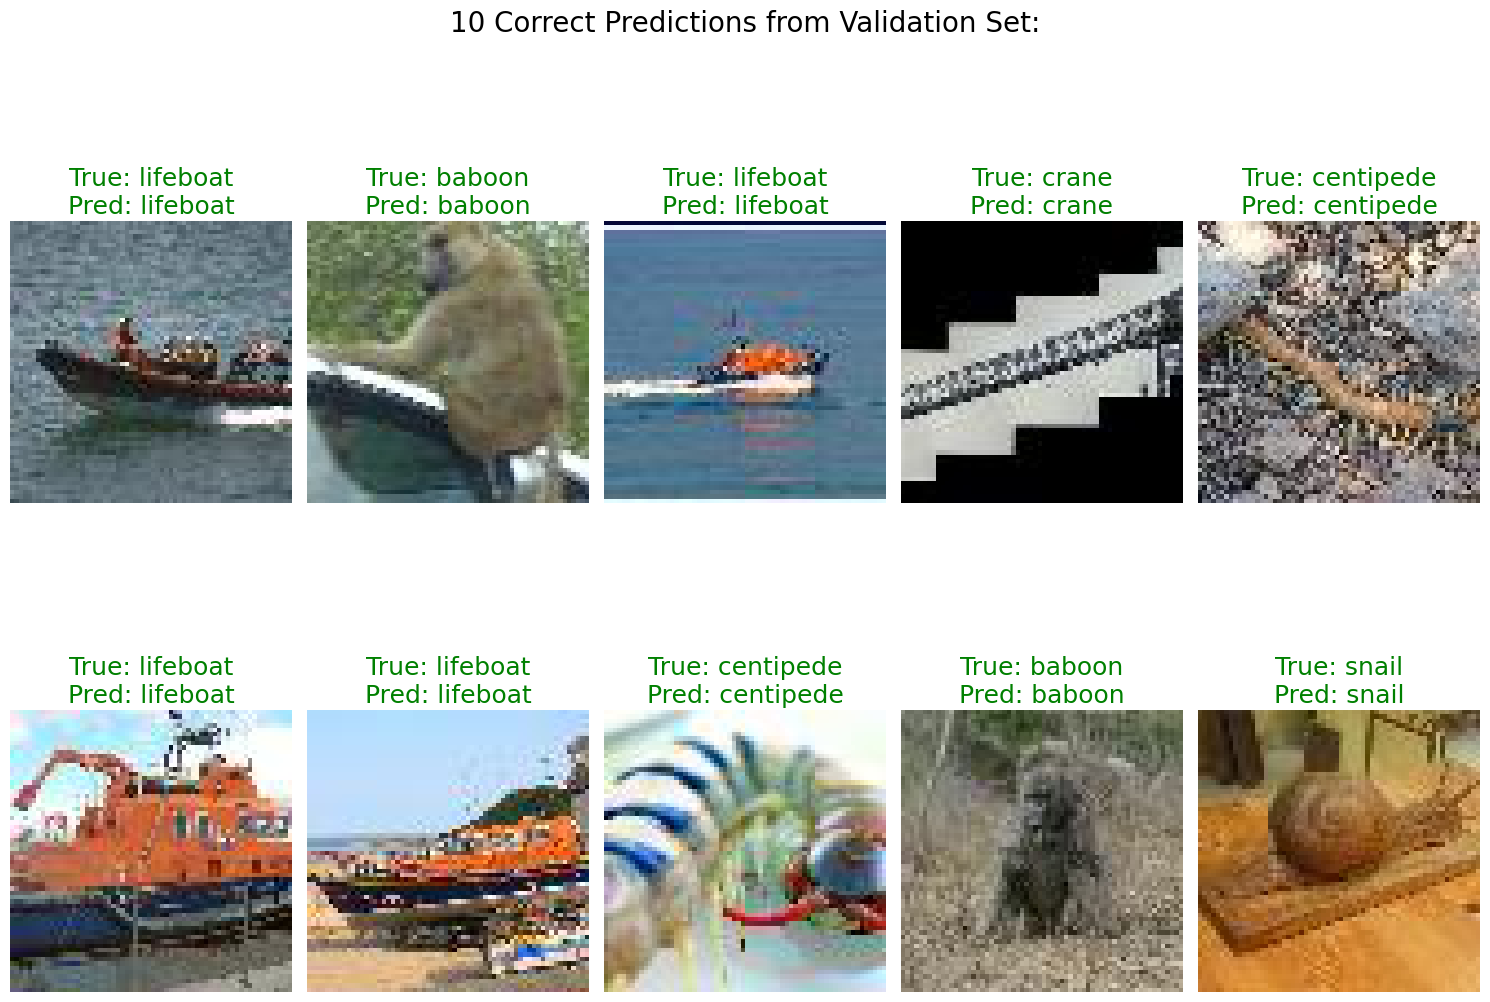

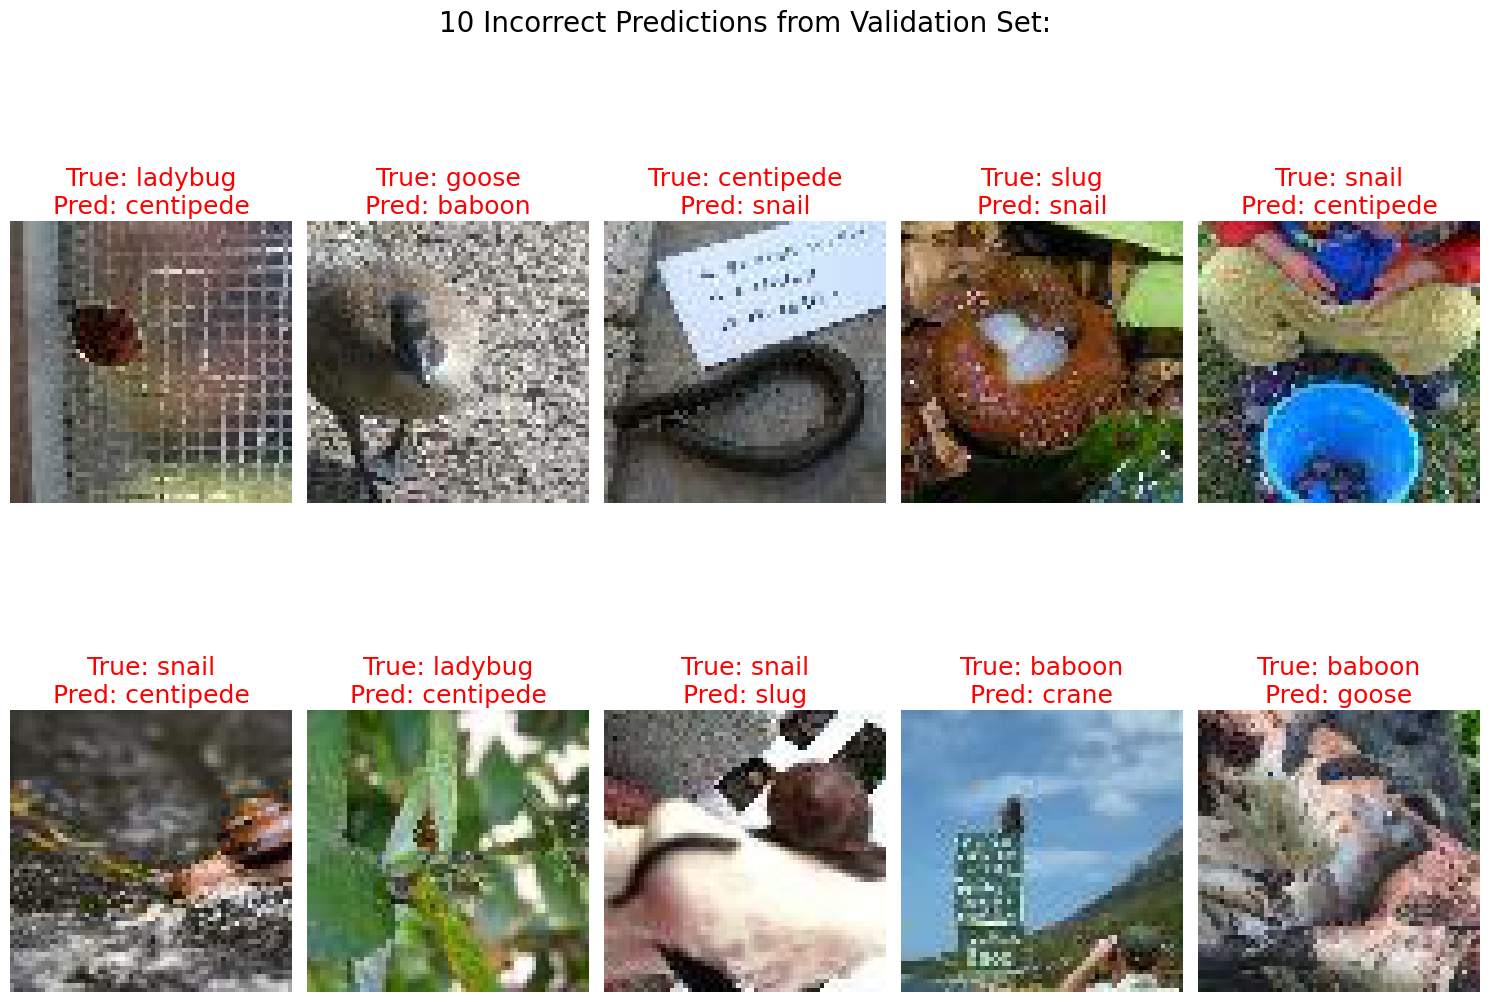

In [24]:
# Ensure using NumPy arrays
X_val_resized_np = X_val.numpy() if isinstance(X_val, tf.Tensor) else X_val
y_val_np = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val
y_val_pred_np = y_val_pred.numpy() if isinstance(y_val_pred_mob, tf.Tensor) else y_val_pred_mob

# Display 10 examples where the model made correct predictions
correct_indices = np.where(y_val_np == y_val_pred_np)[0][:10]
displayImages(X_val_resized_np[correct_indices], y_val_np[correct_indices], class_names, 
              num_images=10, rows=2, cols=5, predictions=y_val_pred_np[correct_indices], 
              title="10 Correct Predictions from Validation Set:")
print("\n\n")
#Display 10 examples where the model made incorrect predictions
incorrect_indices = np.where(y_val_np != y_val_pred_np)[0][:10]
displayImages(X_val_resized_np[incorrect_indices], y_val_np[incorrect_indices], class_names, 
              num_images=10, rows=2, cols=5, predictions=y_val_pred_np[incorrect_indices], 
              title="10 Incorrect Predictions from Validation Set:")

## 2.5 Comparisons

### 2.5.1 Load the two model

In [17]:
# load the two model
cnn_model = load_model("Qin_Long-CNN.keras")
mobilenet_model = load_model("Qin_Long-MobileNetV2.keras")

### 2.5.2 performance metrics

In [18]:
# Make predictions
cnn_train_pred = cnn_model.predict(X_train)
cnn_val_pred = cnn_model.predict(X_val)
mobilenet_train_pred = mobilenet_model.predict(X_train_resized)
mobilenet_val_pred = mobilenet_model.predict(X_val_resized)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


### 2.5.3 Output the Accuracy, F1 and Precision per class

In [19]:
def compute_metrics(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average=None)
    return accuracy, f1, precision

In [20]:
# Compute metrics for CNN
cnn_train_metrics = compute_metrics(y_train, cnn_train_pred)
cnn_val_metrics = compute_metrics(y_val, cnn_val_pred)

# Compute metrics for MobileNetV2
mobilenet_train_metrics = compute_metrics(y_train, mobilenet_train_pred)
mobilenet_val_metrics = compute_metrics(y_val, mobilenet_val_pred)

In [21]:
# Print comparison results
print("\n\n" + "-" * 50)
print("Performance Comparison: CNN vs MobileNetV2:")
print("-" * 50)
print(f"{'Metric':<20} {'CNN (Train)':<15} {'CNN (Val)':<15} {'MobileNetV2 (Train)':<20} {'MobileNetV2 (Val)':<15}")
print(f"{'Accuracy':<20} {cnn_train_metrics[0]:.4f}{' '*10} {cnn_val_metrics[0]:.4f}{' '*10} {mobilenet_train_metrics[0]:.4f}{' '*15} {mobilenet_val_metrics[0]:.4f}")
print(f"{'F1 Score':<20} {cnn_train_metrics[1]:.4f}{' '*10} {cnn_val_metrics[1]:.4f}{' '*10} {mobilenet_train_metrics[1]:.4f}{' '*15} {mobilenet_val_metrics[1]:.4f}")
print("\n\n" + "-" * 50)
print("Precision per class:")
print("-" * 50)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {cnn_train_metrics[2][i]:.4f}{' '*10} {cnn_val_metrics[2][i]:.4f}{' '*10} {mobilenet_train_metrics[2][i]:.4f}{' '*15} {mobilenet_val_metrics[2][i]:.4f}")




--------------------------------------------------
Performance Comparison: CNN vs MobileNetV2:
--------------------------------------------------
Metric               CNN (Train)     CNN (Val)       MobileNetV2 (Train)  MobileNetV2 (Val)
Accuracy             0.9990           0.6360           1.0000                0.8840
F1 Score             0.9990           0.6338           1.0000                0.8843


--------------------------------------------------
Precision per class:
--------------------------------------------------
albatross       0.9950           0.5909           1.0000                0.9130
baboon          1.0000           0.6863           1.0000                0.9592
centipede       1.0000           0.4906           1.0000                0.8542
crane           1.0000           0.7727           1.0000                0.9200
goldfish        1.0000           0.9333           1.0000                0.8727
goose           0.9950           0.5000           1.0000                

### 2.5.4 Complexity

In [22]:
# Compare model complexity
cnn_params = cnn_model.count_params()
mobilenet_params = mobilenet_model.count_params()

print(f"\nModel Complexity:")
print(f"CNN Trainable Parameters: {cnn_params}")
print(f"MobileNetV2 Trainable Parameters: {mobilenet_params}")


Model Complexity:
CNN Trainable Parameters: 3687946
MobileNetV2 Trainable Parameters: 2423242


### 2.5.5 Time per epoch 


CNN -- Model:  **23.2s**   
Mobile Model:     **14.0s**
- I write the **`TimePerEpochCallback`** class in `2.3.1` with `time`.
- Then, create a time_callback `object` in `model.fit()` to track the training time as required.

### 2.5.6 Visual Comparison of CNN and MobileNetV2

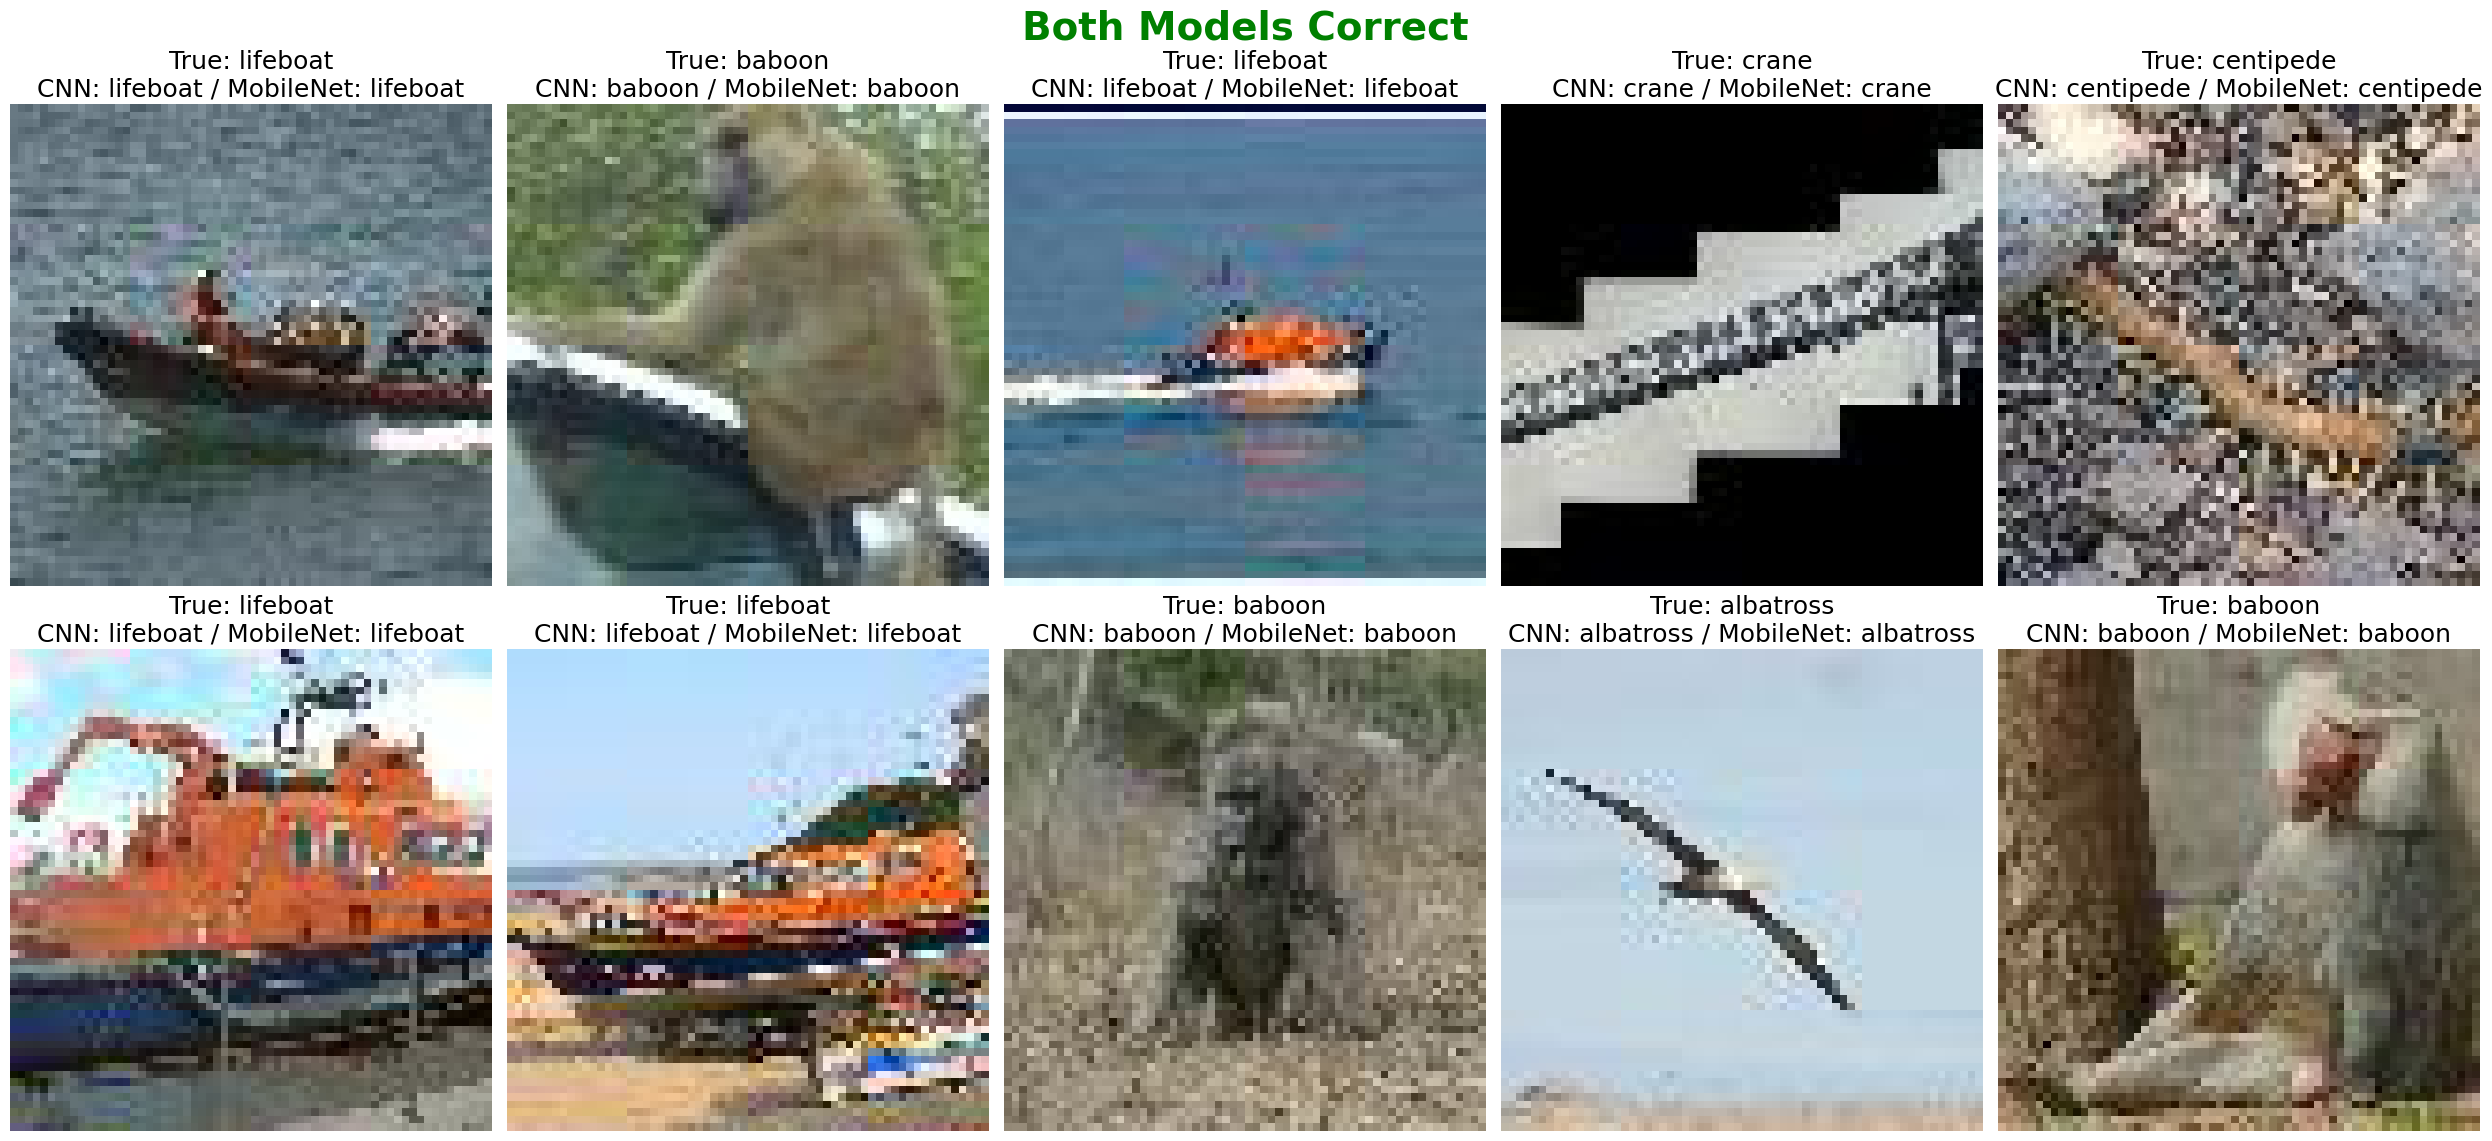

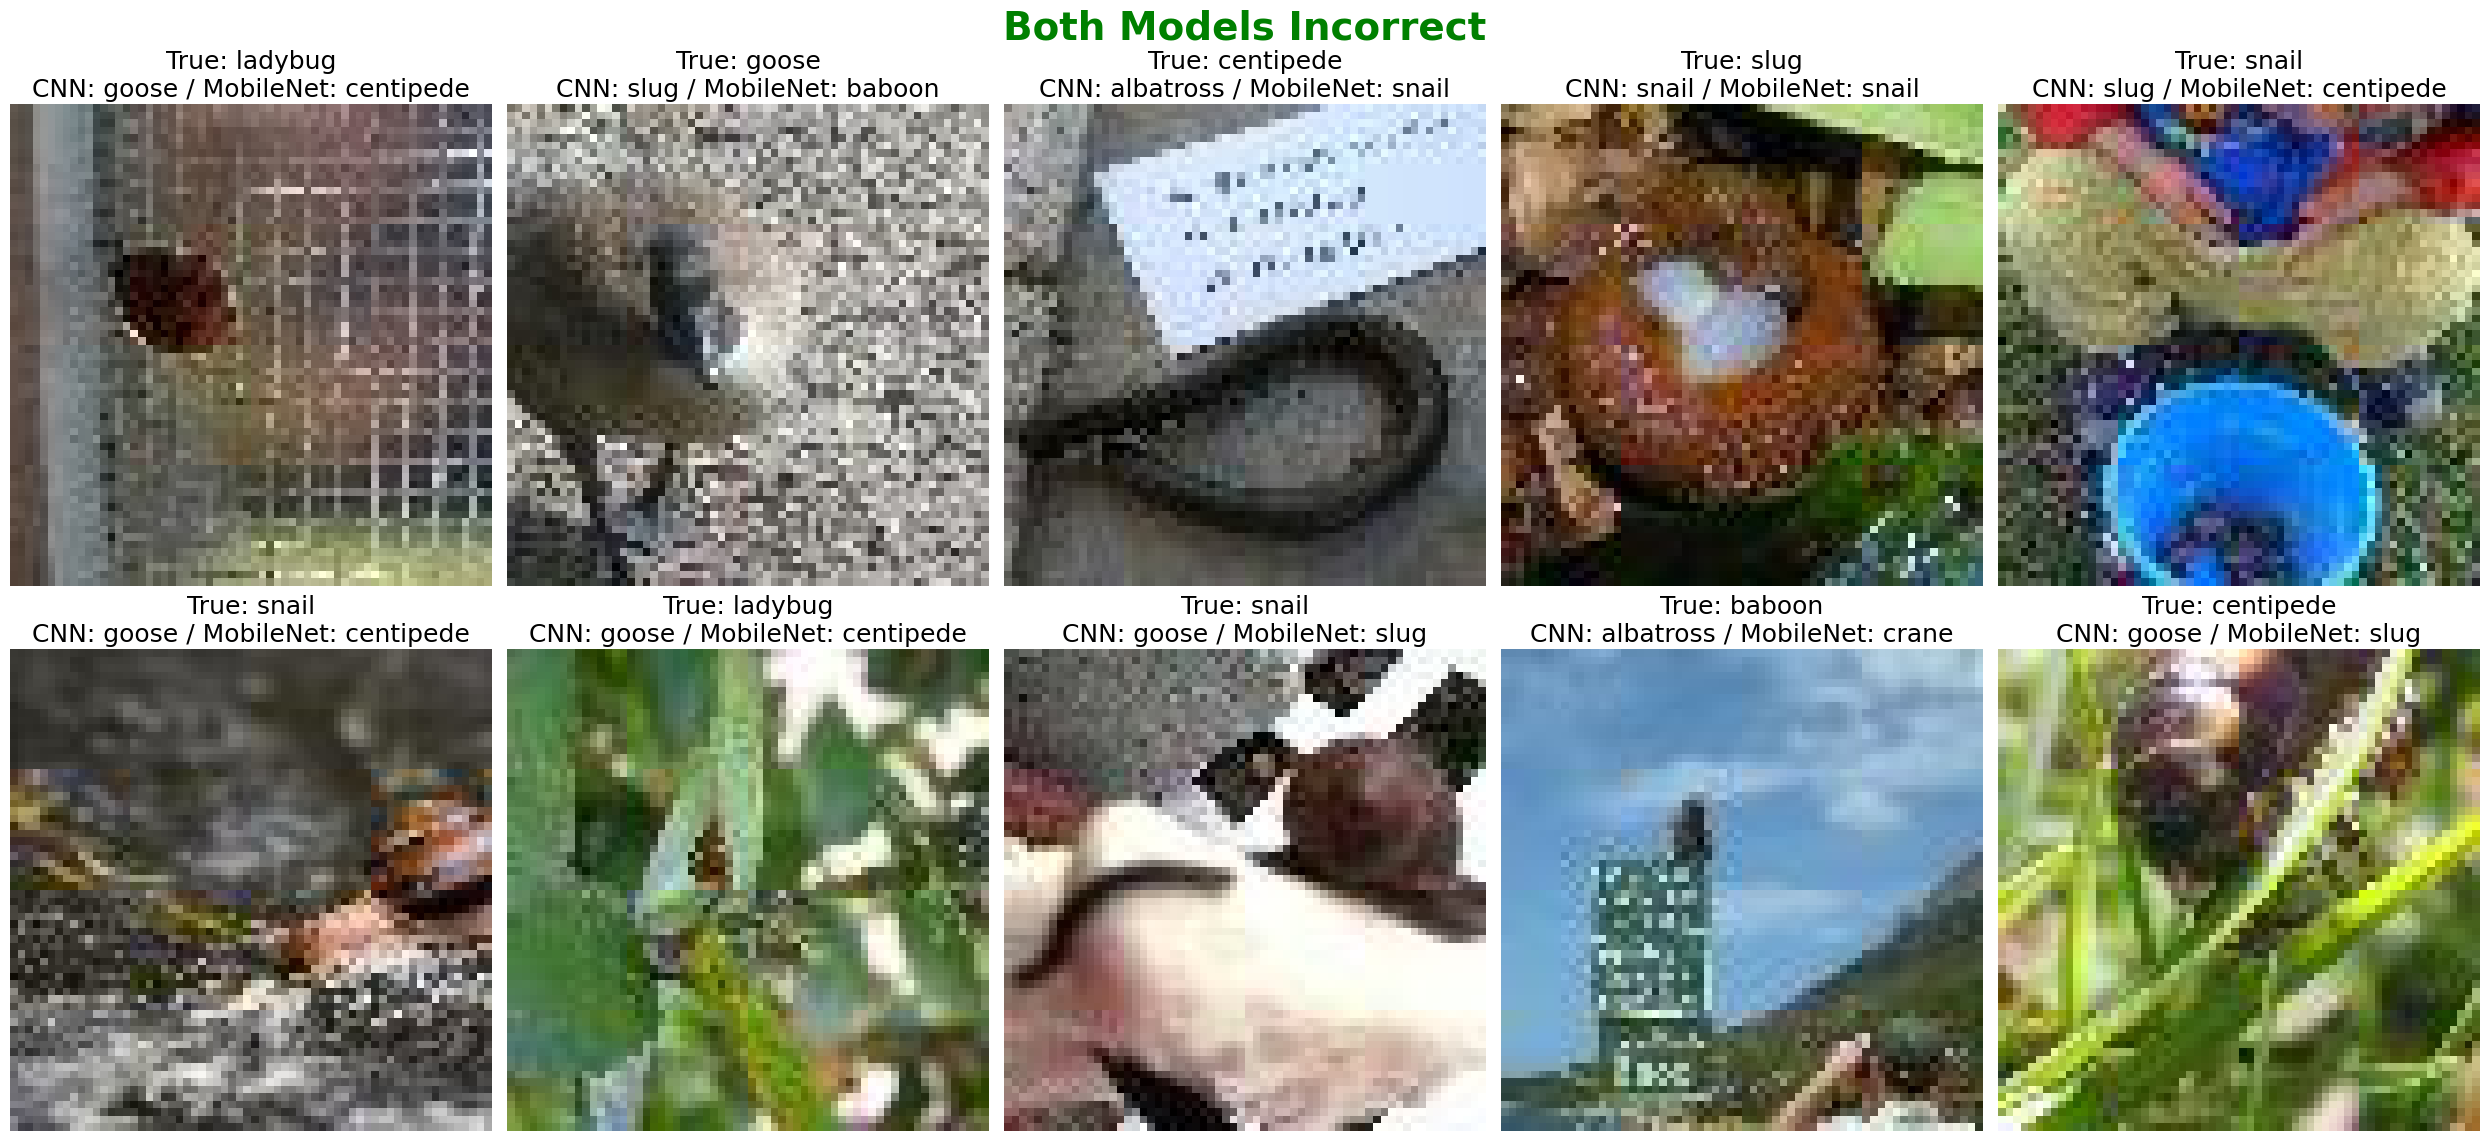

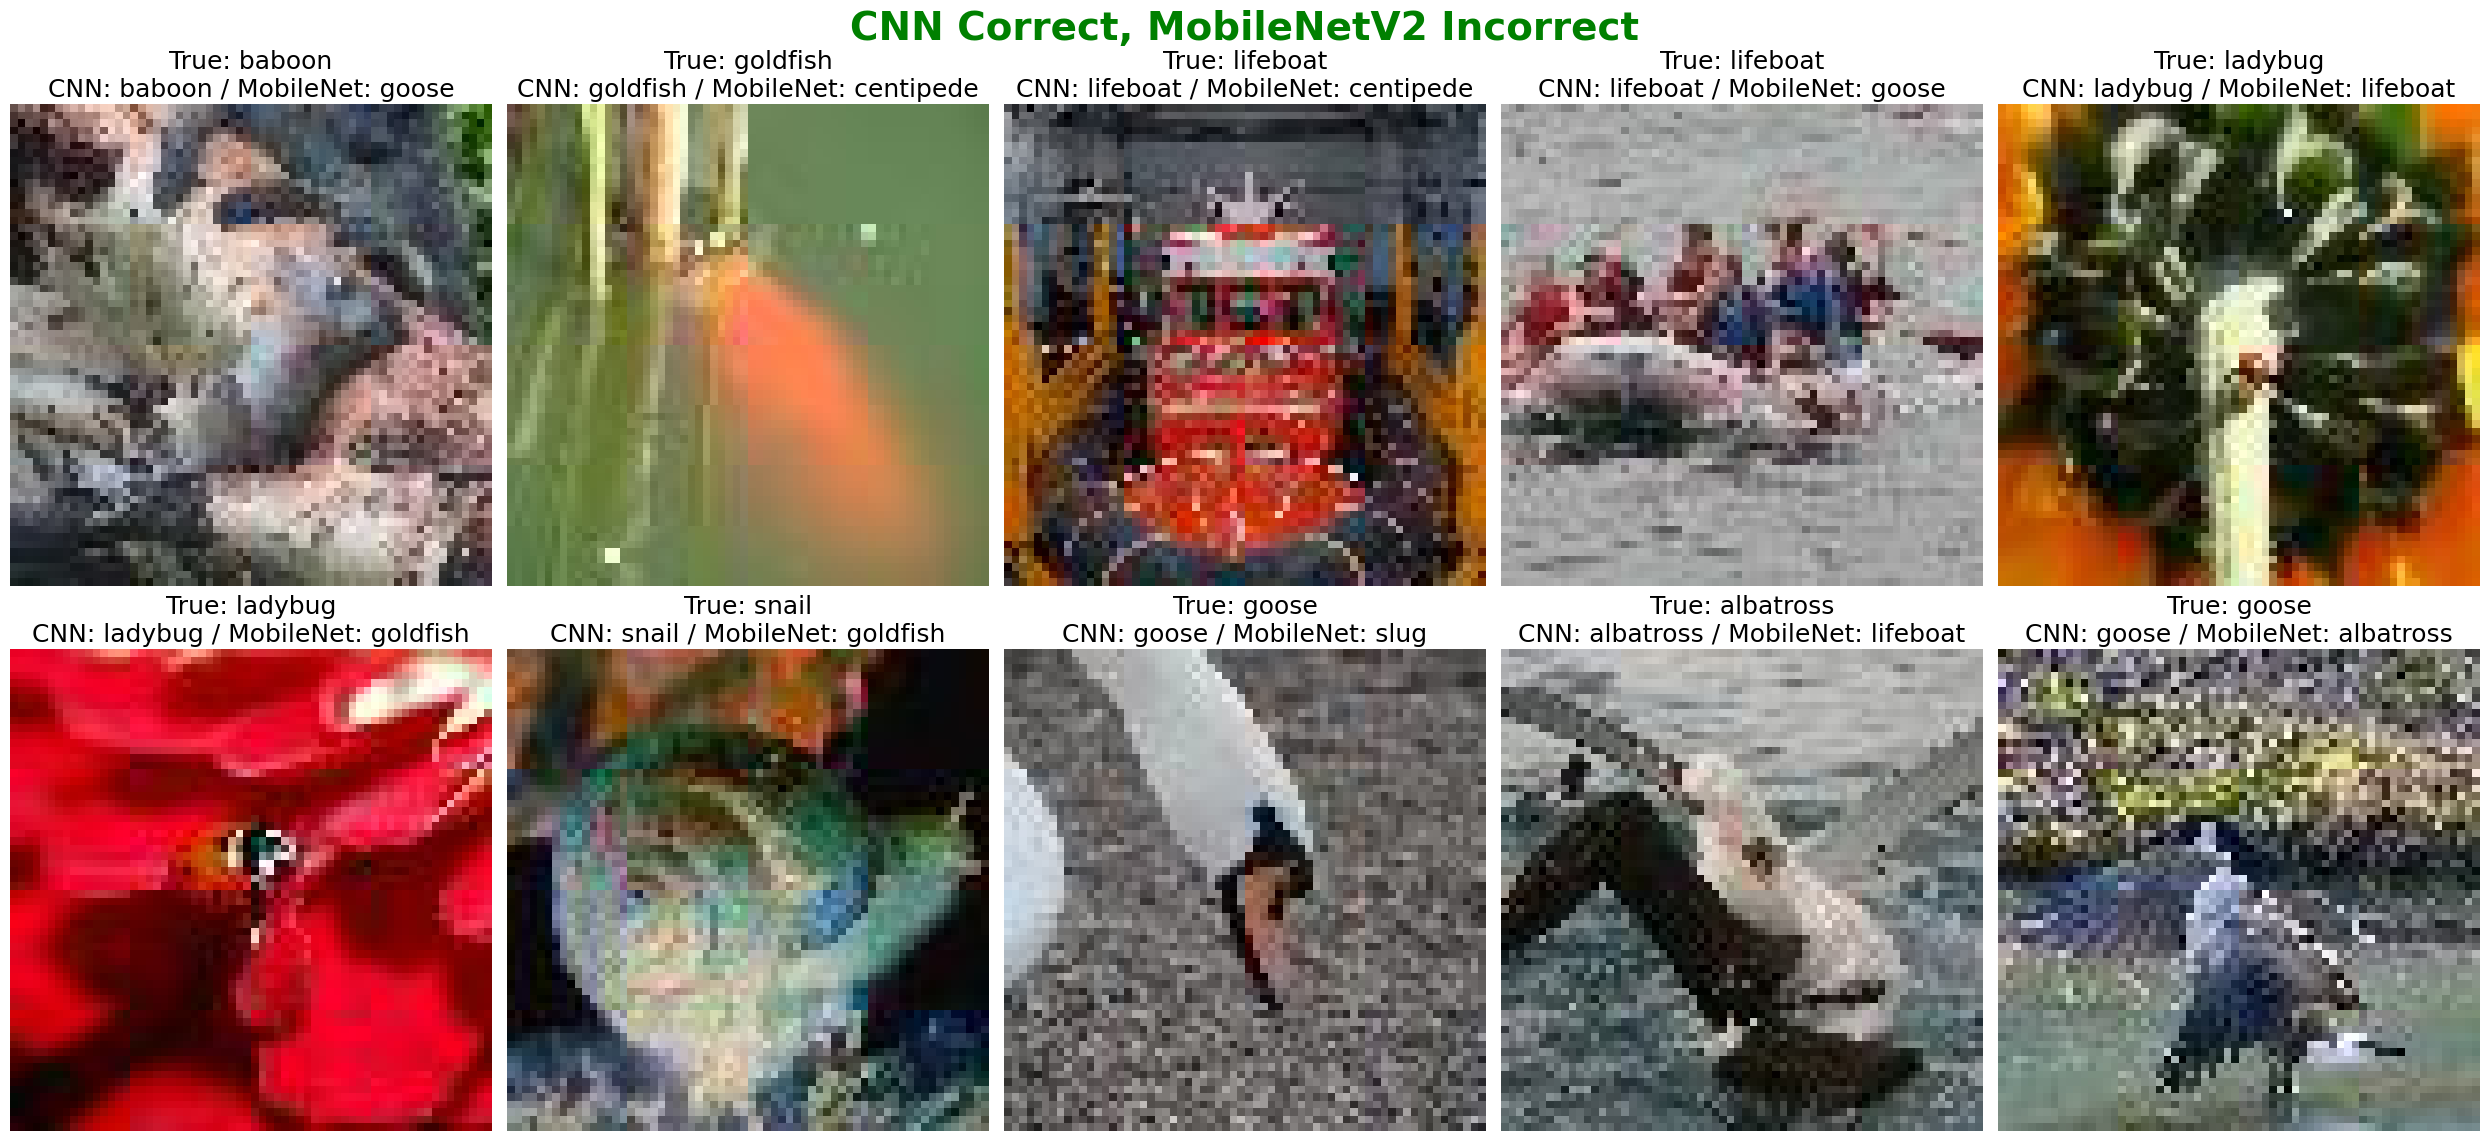

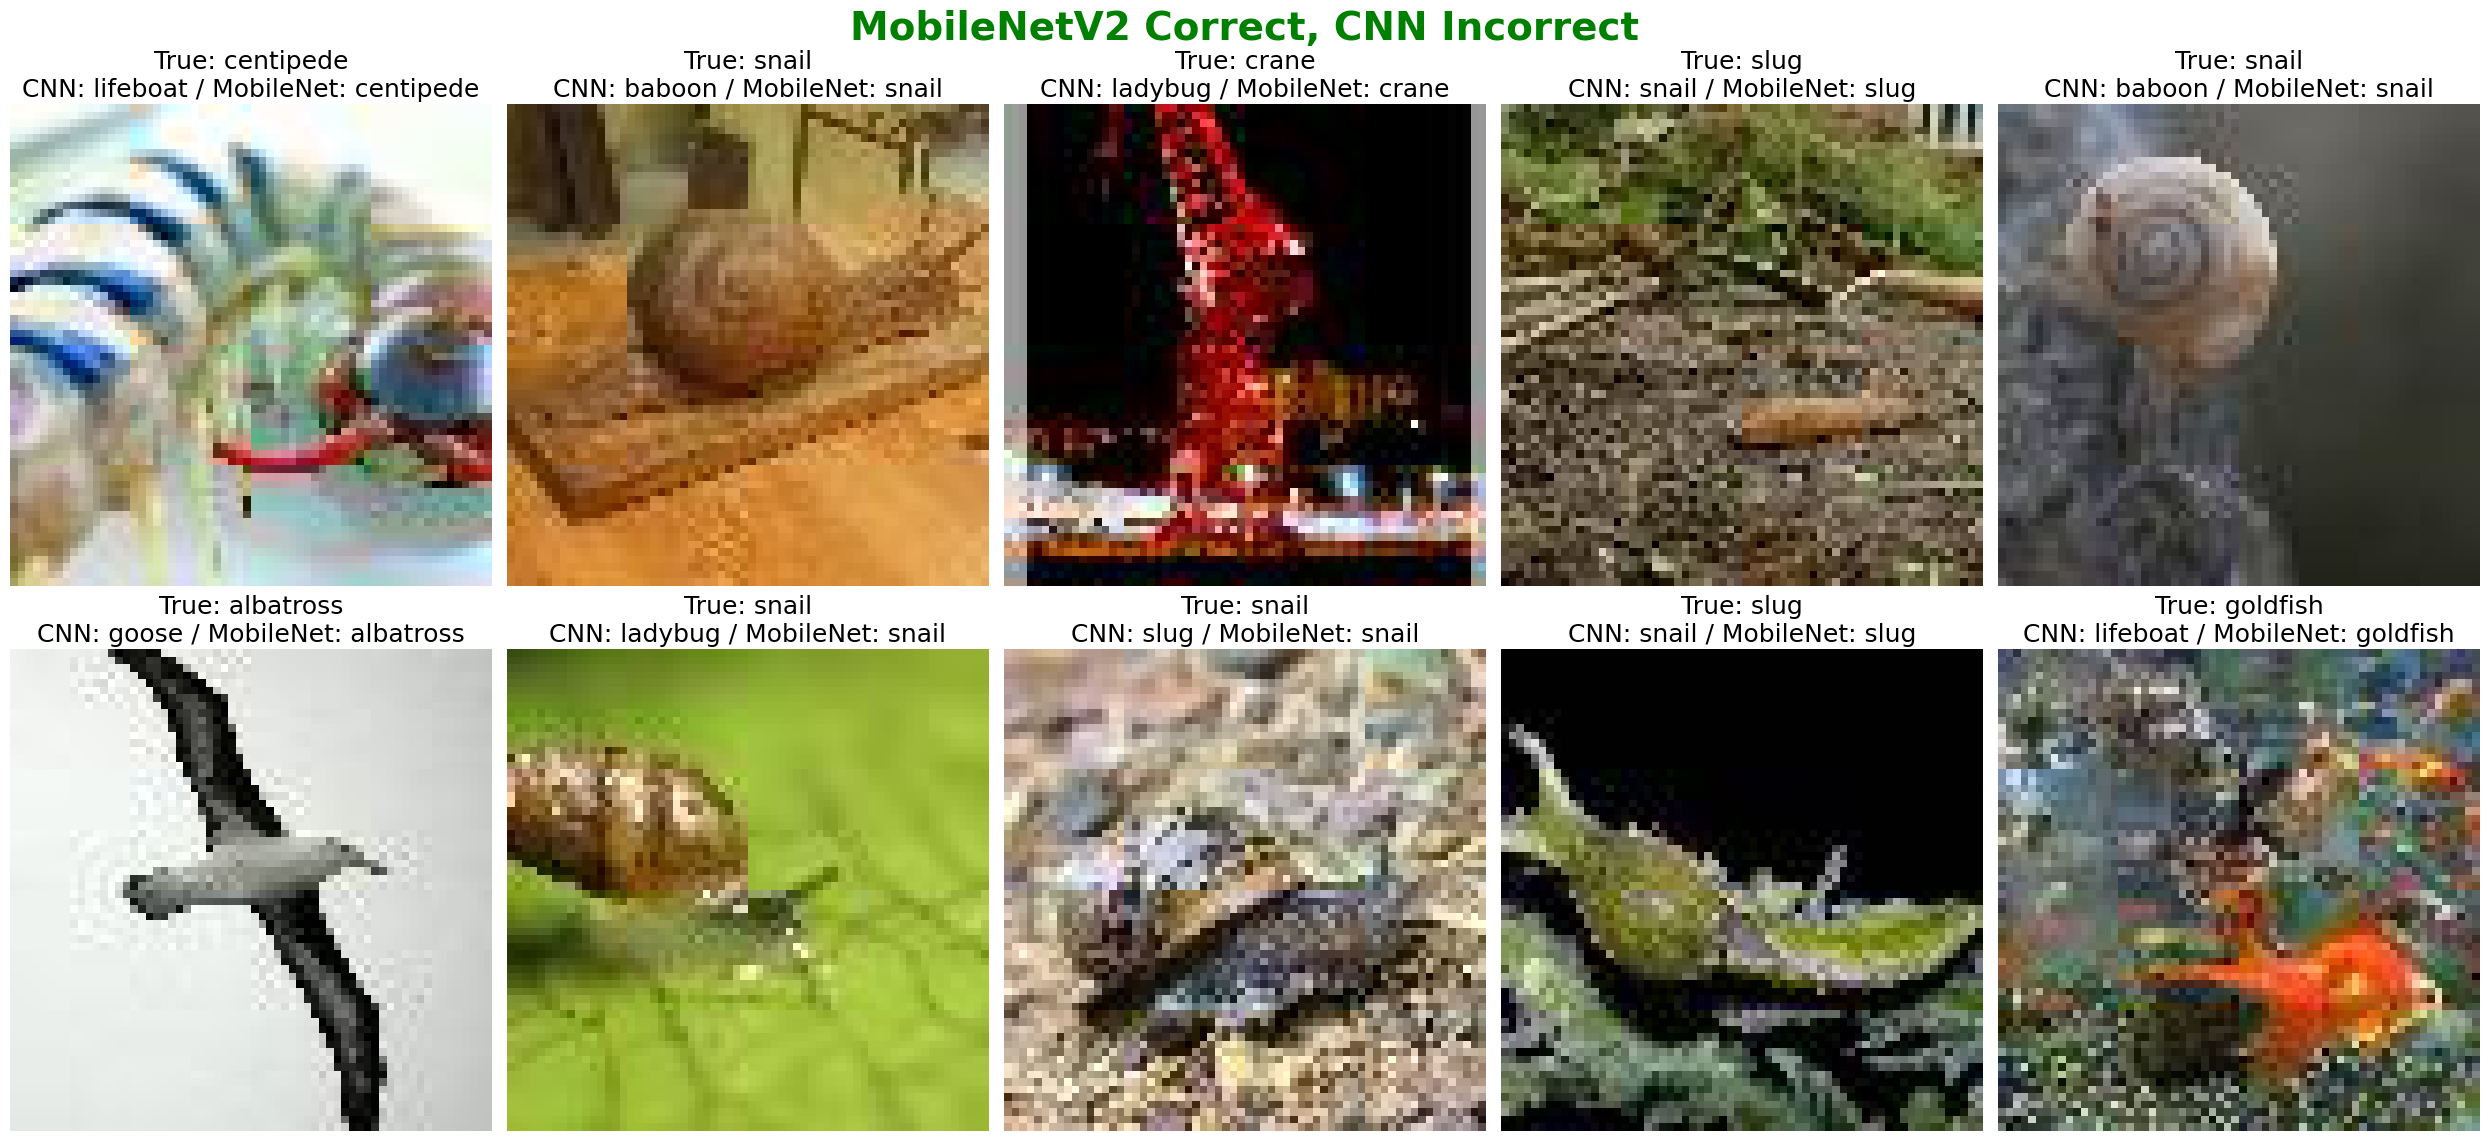



Comparison Statistics:
both_correct: 304 images
both_incorrect: 44 images
cnn_correct_mobilenet_incorrect: 14 images
mobilenet_correct_cnn_incorrect: 138 images


In [23]:
def get_comparison_indices(y_true, y_pred_cnn, y_pred_mobilenet):
    pred_cnn = np.argmax(y_pred_cnn, axis=1)
    pred_mobilenet = np.argmax(y_pred_mobilenet, axis=1)
    
    both_correct = np.where((pred_cnn == y_true) & (pred_mobilenet == y_true))[0]
    both_incorrect = np.where((pred_cnn != y_true) & (pred_mobilenet != y_true))[0]
    cnn_correct_mobilenet_incorrect = np.where((pred_cnn == y_true) & (pred_mobilenet != y_true))[0]
    mobilenet_correct_cnn_incorrect = np.where((pred_cnn != y_true) & (pred_mobilenet == y_true))[0]
    
    return {
        'both_correct': both_correct,
        'both_incorrect': both_incorrect,
        'cnn_correct_mobilenet_incorrect': cnn_correct_mobilenet_incorrect,
        'mobilenet_correct_cnn_incorrect': mobilenet_correct_cnn_incorrect
    }

def plot_comparison_images(X_val, y_val, y_pred_cnn, y_pred_mobilenet, indices, title, class_names, max_images=10):
    n = min(len(indices), max_images)
    fig, axes = plt.subplots(2, 5, figsize=(25, 12))
    fig.suptitle(title, fontsize=28, fontweight='bold',color='green', )
    
    for i, ax in enumerate(axes.flat):
        if i < n:
            idx = indices[i]
            ax.imshow(X_val[idx])
            true_label = class_names[y_val[idx]]
            cnn_pred = class_names[np.argmax(y_pred_cnn[idx])]
            mobilenet_pred = class_names[np.argmax(y_pred_mobilenet[idx])]
            ax.set_title(f"True: {true_label}\nCNN: {cnn_pred} / MobileNet: {mobilenet_pred}", fontsize=18)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    print('\n')

# Get comparison indices
comparison_indices = get_comparison_indices(y_val, cnn_val_pred, mobilenet_val_pred)

# Plot comparison images
plot_comparison_images(X_val, y_val, cnn_val_pred, mobilenet_val_pred, 
                       comparison_indices['both_correct'], "Both Models Correct", class_names)
plot_comparison_images(X_val, y_val, cnn_val_pred, mobilenet_val_pred, 
                       comparison_indices['both_incorrect'], "Both Models Incorrect", class_names)
plot_comparison_images(X_val, y_val, cnn_val_pred, mobilenet_val_pred, 
                       comparison_indices['cnn_correct_mobilenet_incorrect'], "CNN Correct, MobileNetV2 Incorrect", class_names)
plot_comparison_images(X_val, y_val, cnn_val_pred, mobilenet_val_pred, 
                       comparison_indices['mobilenet_correct_cnn_incorrect'], "MobileNetV2 Correct, CNN Incorrect", class_names)

# Print some statistics
print("Comparison Statistics:")
for key, value in comparison_indices.items():
    print(f"{key}: {len(value)} images")

#### Explaination:
1. MobileNetV2 outperforms CNN overall
2. MobileNetV2 Advantages:
   - MobileNetV2 correctly classified 138 cases that CNN misclassified, showing its generalization capability.
   - MobileNetV2 accurately identifying complex cases that CNN misclassified, such as centipedes and slugs.
3. CNN correctly identifying some cases that MobileNetV2 misclassified, such as snails and goldfish.

# END